In [48]:
# Imports

import pandas as pd
import numpy as np
import re
from Scripts.normalize_data import getTrueLabelsDataframe, getCleanDataframe, getCleanAiDataframe, apply_normalizations, loadFormattedSastResults, loadAiAnalysisResults
from Scripts.functions import reder, bench_it
from pathlib import Path
import os
import seaborn as sns


In [42]:
df_ground_truth = getTrueLabelsDataframe()

## Loading Data to analyse


In [43]:
sast_results = loadFormattedSastResults('..\\volume\\sast\\formatted')
ai_results = loadAiAnalysisResults('..\\volume\\sast\\ai_analysis')

def merge_resultados(df_base, lista_dfs, coluna_chave="filename"):
    df_final = df_base.copy()

    for df in lista_dfs:
        colunas_resultado = [c for c in df.columns if c != coluna_chave]

        df_final = df_final.merge(
            df[[coluna_chave] + colunas_resultado],
            on=coluna_chave,
            how="left"
        )

    return df_final

all = ai_results + sast_results

labels = merge_resultados(df_ground_truth, all)


In [44]:
def remove_spaces(text):
    return re.sub(r'(\d) +\(', r'\1(', text)

labels['true_label'] = labels['true_label'].apply(remove_spaces)


## Evaluating the results




In [45]:

predictions = {}

for column in labels.columns:

    if(column not in ['filename', 'true_label']):
        preds = reder(labels, column)
        predictions[column] = preds

#Generating list of expected values
exploded_labels = labels['true_label'].str.split(',').explode()
dist_labels = (exploded_labels.index.astype(str) + '-' + exploded_labels).values



In [46]:
rows = []

for tool, preds in predictions.items():
    precision, recall, f1 = bench_it(dist_labels, preds)
    
    rows.append({
        'Tool': tool,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

report_df = pd.DataFrame(rows)

report_df

,Tool,Precision,Recall,F1 Score
0,bandit-chat_gpt.json,0.273973,0.038536,0.067568
1,bandit-claude.json,0.219512,0.034682,0.059900
2,bandit-deepseek.json,0.181818,0.030829,0.052718
3,bandit-gemini.json,0.358209,0.046243,0.081911
4,semgrep-chat_gpt.json,0.461538,0.069364,0.120603
5,semgrep-claude.json,0.324324,0.046243,0.080944
6,semgrep-deepseek.json,0.346667,0.050096,0.087542
7,semgrep-gemini.json,0.518519,0.080925,0.140000
8,bandit.json,0.285714,0.057803,0.096154
9,semgrep.json,0.677778,0.117534,0.200328


<Axes: xlabel='Precision', ylabel='Tool'>

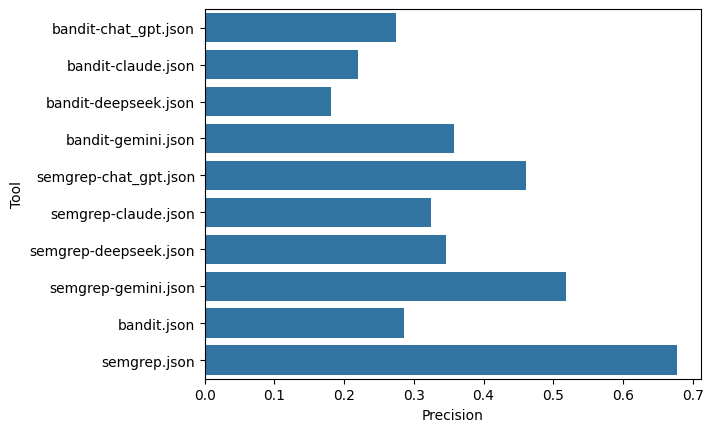

In [50]:
sns.barplot(report_df, x="Precision" , y="Tool")